In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt 
from sklearn.covariance import EmpiricalCovariance
import statsmodels.api as sm

In [2]:
df = pd.read_csv('gp_data_1986_to_2015.csv')
df.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.56,7.92,2.38,-1.20,-0.86,5.55,2.14,3.91,...,0.78,-1.11,0.85,3.80,4.61,1.91,5.60,2.48,1.67,-0.09
1,198602,7.13,0.53,13.98,7.89,11.68,7.71,12.20,10.72,8.28,...,7.47,2.71,8.34,9.98,8.68,10.61,7.03,8.85,7.21,9.27
2,198603,4.88,0.60,2.74,7.84,10.89,9.17,11.52,5.65,6.86,...,4.96,-0.11,0.04,-1.15,4.18,5.61,3.22,7.41,9.11,6.42
3,198604,-1.31,0.52,5.24,-0.57,4.44,-2.92,3.64,3.91,8.36,...,3.33,3.87,3.55,2.69,-2.50,-0.93,-2.64,1.70,-0.70,3.86
4,198605,4.62,0.49,1.08,8.55,7.95,6.37,10.16,3.16,5.91,...,5.41,1.01,-0.75,2.51,6.66,5.07,0.70,5.52,11.95,4.89


In [3]:
print(df.columns.values)

['Month' 'Mkt-RF' 'RF' 'Agric' 'Food ' 'Soda ' 'Beer ' 'Smoke' 'Toys '
 'Fun  ' 'Books' 'Hshld' 'Clths' 'Hlth ' 'MedEq' 'Drugs' 'Chems' 'Rubbr'
 'Txtls' 'BldMt' 'Cnstr' 'Steel' 'FabPr' 'Mach ' 'ElcEq' 'Autos' 'Aero '
 'Ships' 'Guns ' 'Gold ' 'Mines' 'Coal ' 'Oil  ' 'Util ' 'Telcm' 'PerSv'
 'BusSv' 'Comps' 'Chips' 'LabEq' 'Paper' 'Boxes' 'Trans' 'Whlsl' 'Rtail'
 'Meals']


In [4]:
print(df.shape)

(360, 46)


In [5]:
# Convert the 'Month' column to string type (if it's not already)
df['Month'] = df['Month'].astype(str)

# Extract the last 2 characters (the month part) and convert to integer
df['Month'] = df['Month'].str[-2:].astype(int)

# If you want to remove the leading zero (so '01' becomes 1), you can alternatively do:
# df['Month'] = df['Month'].str[-2:].astype(int)
df.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,1,0.65,0.56,7.92,2.38,-1.20,-0.86,5.55,2.14,3.91,...,0.78,-1.11,0.85,3.80,4.61,1.91,5.60,2.48,1.67,-0.09
1,2,7.13,0.53,13.98,7.89,11.68,7.71,12.20,10.72,8.28,...,7.47,2.71,8.34,9.98,8.68,10.61,7.03,8.85,7.21,9.27
2,3,4.88,0.60,2.74,7.84,10.89,9.17,11.52,5.65,6.86,...,4.96,-0.11,0.04,-1.15,4.18,5.61,3.22,7.41,9.11,6.42
3,4,-1.31,0.52,5.24,-0.57,4.44,-2.92,3.64,3.91,8.36,...,3.33,3.87,3.55,2.69,-2.50,-0.93,-2.64,1.70,-0.70,3.86
4,5,4.62,0.49,1.08,8.55,7.95,6.37,10.16,3.16,5.91,...,5.41,1.01,-0.75,2.51,6.66,5.07,0.70,5.52,11.95,4.89


In [6]:
# Replace the return rate of every asset with the excess return rate

# Calculate the risk-free rate for all assets
Rf = df['RF'].values.copy()
for column in df.columns:
    if column in ['Month','Mkt-RF','RF']:
        continue
    df[column] -= Rf

df.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,1,0.65,0.56,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
1,2,7.13,0.53,13.45,7.36,11.15,7.18,11.67,10.19,7.75,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
2,3,4.88,0.60,2.14,7.24,10.29,8.57,10.92,5.05,6.26,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
3,4,-1.31,0.52,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
4,5,4.62,0.49,0.59,8.06,7.46,5.88,9.67,2.67,5.42,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


In [7]:

rf = df['RF'] 
mkt_excess = df['Mkt-RF']
industries = df.iloc[:, 3:]  # extract the industry return data
print(industries)


# Calculate the expected return for all assets
mean_return = industries.mean() * 12

# Calculate the standard deviation for all assets
std_dev = industries.std() * np.sqrt(12)

# Calculate the Sharpe Ratio
sharpe_ratio = (mean_return / std_dev) * np.sqrt(12)

# Calculate the beta for all assets
industries['Mkt-RF'] = mkt_excess
cov_matrix = industries.cov()
beta = cov_matrix['Mkt-RF'] / mkt_excess.var()
beta = beta.drop('Mkt-RF') # remove the market beta to prepare for the CAPM

# Summary for all assets
summary = pd.DataFrame({
    'Expected Return': mean_return,
    'Std Dev': std_dev,
    'Sharpe Ratio': sharpe_ratio,
    'Beta': beta
})
summary.index = summary.index.str.strip()
# Annual return
exp_mkt = mkt_excess.mean() * 12

# Annual standard deviation
std_mkt = mkt_excess.std() * np.sqrt(12)

# Sharpe ratio for the market
sharpe_mkt = (mkt_excess.mean() / mkt_excess.std()) * np.sqrt(12)

# Annual risk-free rate
rf_annual = rf.mean() * 12 

print(summary)

     Agric  Food   Soda   Beer   Smoke  Toys   Fun    Books  Hshld  Clths  \
0     7.36   1.82  -1.76  -1.42   4.99   1.58   3.35  -1.34  -1.52   4.66   
1    13.45   7.36  11.15   7.18  11.67  10.19   7.75  14.14  10.20   8.80   
2     2.14   7.24  10.29   8.57  10.92   5.05   6.26   4.47   4.97   5.57   
3     4.72  -1.09   3.92  -3.44   3.12   3.39   7.84  -1.66  -2.18  -3.30   
4     0.59   8.06   7.46   5.88   9.67   2.67   5.42  10.47   4.12   9.29   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
355  -4.59  -4.22  -4.57  -3.12  -4.06  -4.83  -7.79  -8.76  -6.94  -3.86   
356 -11.16  -1.73   2.15   2.58   2.37  -5.42 -10.75  -5.65  -0.53   1.18   
357   8.63   5.44   5.77   8.06  10.90  11.86  15.14  12.44   5.81   0.98   
358   1.87  -1.59   2.36  -0.71  -3.00  -2.23  -0.08  -0.06  -1.10  -1.08   
359   2.06   2.97   0.41   0.30   1.59  -2.42  -1.56  -5.95   1.86  -4.38   

     ...  BusSv  Comps  Chips  LabEq  Paper  Boxes  Trans  Whlsl  Rtail  Me

In [8]:
industries.columns = industries.columns.astype(str).str.strip()
industries = industries.drop(columns='Mkt-RF')
print(industries.columns.tolist())

['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books', 'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero', 'Ships', 'Guns', 'Gold', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals']


In [9]:
# Split the historical data into two parts: 
# The first 200 data points belong to the "training" data
# The rest of data points belong to the "testing" data

# Remove any leading/trailing whitespace from column names
industries.columns = industries.columns.str.strip()

# Define the list of industry column names
industry_cols = ['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 
                 'Books', 'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 
                 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 
                 'ElcEq', 'Autos', 'Aero', 'Ships', 'Guns', 'Gold', 'Mines', 
                 'Coal', 'Oil', 'Util', 'Telcm', 'PerSv', 'BusSv', 'Comps', 
                 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail', 
                 'Meals']

# Now extract those columns explicitly
data_sampling = industries[industry_cols]
#data_test = df[industry_cols].iloc[200:]

print(data_sampling)



     Agric  Food   Soda  Beer  Smoke   Toys    Fun  Books  Hshld  Clths  ...  \
0     7.36  1.82  -1.76 -1.42   4.99   1.58   3.35  -1.34  -1.52   4.66  ...   
1    13.45  7.36  11.15  7.18  11.67  10.19   7.75  14.14  10.20   8.80  ...   
2     2.14  7.24  10.29  8.57  10.92   5.05   6.26   4.47   4.97   5.57  ...   
3     4.72 -1.09   3.92 -3.44   3.12   3.39   7.84  -1.66  -2.18  -3.30  ...   
4     0.59  8.06   7.46  5.88   9.67   2.67   5.42  10.47   4.12   9.29  ...   
..     ...   ...    ...   ...    ...    ...    ...    ...    ...    ...  ...   
355  -4.59 -4.22  -4.57 -3.12  -4.06  -4.83  -7.79  -8.76  -6.94  -3.86  ...   
356 -11.16 -1.73   2.15  2.58   2.37  -5.42 -10.75  -5.65  -0.53   1.18  ...   
357   8.63  5.44   5.77  8.06  10.90  11.86  15.14  12.44   5.81   0.98  ...   
358   1.87 -1.59   2.36 -0.71  -3.00  -2.23  -0.08  -0.06  -1.10  -1.08  ...   
359   2.06  2.97   0.41  0.30   1.59  -2.42  -1.56  -5.95   1.86  -4.38  ...   

     BusSv  Comps  Chips  LabEq  Paper 

In [10]:
print(industries)

     Agric  Food   Soda  Beer  Smoke   Toys    Fun  Books  Hshld  Clths  ...  \
0     7.36  1.82  -1.76 -1.42   4.99   1.58   3.35  -1.34  -1.52   4.66  ...   
1    13.45  7.36  11.15  7.18  11.67  10.19   7.75  14.14  10.20   8.80  ...   
2     2.14  7.24  10.29  8.57  10.92   5.05   6.26   4.47   4.97   5.57  ...   
3     4.72 -1.09   3.92 -3.44   3.12   3.39   7.84  -1.66  -2.18  -3.30  ...   
4     0.59  8.06   7.46  5.88   9.67   2.67   5.42  10.47   4.12   9.29  ...   
..     ...   ...    ...   ...    ...    ...    ...    ...    ...    ...  ...   
355  -4.59 -4.22  -4.57 -3.12  -4.06  -4.83  -7.79  -8.76  -6.94  -3.86  ...   
356 -11.16 -1.73   2.15  2.58   2.37  -5.42 -10.75  -5.65  -0.53   1.18  ...   
357   8.63  5.44   5.77  8.06  10.90  11.86  15.14  12.44   5.81   0.98  ...   
358   1.87 -1.59   2.36 -0.71  -3.00  -2.23  -0.08  -0.06  -1.10  -1.08  ...   
359   2.06  2.97   0.41  0.30   1.59  -2.42  -1.56  -5.95   1.86  -4.38  ...   

     BusSv  Comps  Chips  LabEq  Paper 

In [11]:
def estimate_V (data):
    
    ###########
    # (Basic) Estimate of the covariance matrix from histrocial return data
    # Input: Histrocial return data
    # Output: The basic estimate of covariance matrix of asset returns
    ###########
    
    Vhat = EmpiricalCovariance().fit(data).covariance_
    
    return Vhat

def estimate_mu (data):
    
    ###########
    # (Basic) Estimate of the expected return vector from histrocial return data
    # Input: Histrocial return data
    # Output: The basic estimate of expected return vector of all assets
    ###########
    
    mu_hat = EmpiricalCovariance().fit(data).location_
    
    return mu_hat

In [12]:
estimate_V (industries)

array([[40.84759509, 10.9137297 , 12.74809793, ..., 15.80665941,
        15.7765677 , 14.39961174],
       [10.9137297 , 19.77064896, 15.37992729, ..., 12.50757045,
        14.17472546, 13.57467529],
       [12.74809793, 15.37992729, 48.89342031, ..., 18.47125604,
        17.44724133, 17.92055246],
       ...,
       [15.80665941, 12.50757045, 18.47125604, ..., 23.7117276 ,
        18.26756111, 17.16651323],
       [15.7765677 , 14.17472546, 17.44724133, ..., 18.26756111,
        28.75849011, 20.85981856],
       [14.39961174, 13.57467529, 17.92055246, ..., 17.16651323,
        20.85981856, 25.71419194]])

In [13]:
np.cov(industries.T)  # for array calculation

array([[40.96137669, 10.94413006, 12.78360795, ..., 15.8506891 ,
        15.82051357, 14.43972208],
       [10.94413006, 19.82572041, 15.42276831, ..., 12.54241048,
        14.21420938, 13.61248776],
       [12.78360795, 15.42276831, 49.02961368, ..., 18.52270801,
        17.49584089, 17.97047043],
       ...,
       [15.8506891 , 12.54241048, 18.52270801, ..., 23.77777698,
        18.31844568, 17.21433081],
       [15.82051357, 14.21420938, 17.49584089, ..., 18.31844568,
        28.83859733, 20.9179239 ],
       [14.43972208, 13.61248776, 17.97047043, ..., 17.21433081,
        20.9179239 , 25.78581921]])

In [14]:
industries.cov() # for visualisation

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
Agric,40.961377,10.944130,12.783608,11.265141,11.891630,17.287909,21.625006,17.437891,11.189786,18.559851,...,18.779991,18.088236,20.937493,20.628768,15.334690,17.972508,16.535737,15.850689,15.820514,14.439722
Food,10.944130,19.825720,15.422768,14.936965,17.233602,14.845313,16.155307,13.715698,13.031216,16.432088,...,11.222386,9.063718,10.150735,12.076864,13.182311,13.623658,12.158738,12.542410,14.214209,13.612488
Soda,12.783608,15.422768,49.029614,20.202642,15.915020,20.341931,25.208378,20.109643,17.484236,22.141277,...,16.512340,16.368218,19.582584,19.612606,19.266075,18.342927,17.776631,18.522708,17.495841,17.970470
Beer,11.265141,14.936965,20.202642,26.082076,15.232939,15.831952,16.450235,12.755868,15.903969,15.140258,...,12.340226,10.364637,12.361894,12.632606,14.581228,13.702061,13.509883,12.103979,14.334868,14.567319
Smoke,11.891630,17.233602,15.915020,15.232939,46.893514,15.879613,16.785073,12.559770,13.509574,14.574751,...,11.953909,11.489008,10.815221,13.674881,15.053872,14.820363,10.837876,15.631230,11.633787,13.165902
Toys,17.287909,14.845313,20.341931,15.831952,15.879613,44.976845,33.628005,23.468988,17.773965,29.489682,...,25.076303,26.506918,29.573561,27.910750,23.864333,25.830694,24.159741,21.470637,23.825517,23.575499
Fun,21.625006,16.155307,25.208378,16.450235,16.785073,33.628005,57.705218,31.645646,19.269888,34.168742,...,33.962362,36.165443,39.294104,35.432952,27.151618,28.500850,27.084409,27.828143,26.879796,26.789620
Books,17.437891,13.715698,20.109643,12.755868,12.559770,23.468988,31.645646,32.784449,15.929399,25.805188,...,24.281937,23.872929,25.805190,24.679990,22.333688,21.805978,21.378956,20.706383,22.357549,18.341370
Hshld,11.189786,13.031216,17.484236,15.903969,13.509574,17.773965,19.269888,15.929399,20.242939,17.007928,...,15.596651,15.037239,16.622607,16.457997,17.118412,15.136752,15.063899,13.457238,15.002601,14.844246
Clths,18.559851,16.432088,22.141277,15.140258,14.574751,29.489682,34.168742,25.805188,17.007928,43.223724,...,25.514177,26.300230,28.111856,26.615236,24.508412,25.076385,25.951479,22.557704,28.490989,24.834806


In [15]:
def tangency(mu, V):
    
    ###########
    # Construct the tangency portfolio using the closed form method
    # Input: mu is Estimated expected vector and V is the estimated covariance matrix
    # Output: The weights of the tangency portfolio
    ###########

    
    #tangency portfolio
    w_t = np.linalg.inv(V) @ mu
    w_t /= np.sum(w_t)

    return w_t


In [16]:
def gmv(V):
    
    ###########
    # Construct the global minimum variance portfolio using the closed form method
    # Input: V is the estimated covariance matrix
    #        NB: the expected return vector is not needed here!
    # Output: The weights of the global minimum variance portfolio
    ###########

    #GMV
    n = len(V)
    w_g = np.linalg.inv(V) @ np.ones(n)
    w_g /= np.sum(w_g)
    
    return w_g

In [17]:
def ewp(n):
    
    ###########
    # Construct the equally weighted portfolio
    # Input: n is the number of assets
    #        NB: neither the expected return vector nor covariance matrix is not needed here!
    # Output: The weights of the equally weighted portfolio
    ###########

    #GMV
    
    return np.ones(n)/n

In [18]:
def evaluate_portfolio_performance_on_data(w, data_evaluate):
    
    ###########
    # Evaluate the performance of a portfolio (i.e., weight vector) given the return data to evaluate on
    # Input: data contains historical return information (every column corresponds to an asset)
    #        w is the portfolio weight vector
    #        (NB: risk-free rate has already been assumed to be zero)
    # Output: The performance metrics of the portfolio 
    #         (i.e., expected return, standard deviation, variance, and Sharpe ratio)
    ###########
    
    # Sanity check for the input format
    w = w.reshape((-1))
    if (data_evaluate.shape[1] != len(w)):
        print('Warning: data and w should contain the same number of assets')
    ### End of sanity check
    
    V = estimate_V (data_evaluate)
    mu = estimate_mu (data_evaluate)
    
    
    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - 0)/(np.sqrt(w.T @ V @ w)) }

In [19]:
def get_EF_on_data (w_t, w_g, data_evaluate):

    ###########
    # Get the (evaluated) efficient frontier curve using the two-fund separation method
    #
    # Input: data contains historical return information to evaluate on (every column corresponds to an asset)
    #        w_t and w_g are the constructed tangency and global minimum variance portfolios, respectively
    #        (NB: if w_t and w_g are obtained from the training data but "data" is actually testing data,
    #         then the output EF could be highly sub-optimal!)
    # Output: The risk-return combinations of portfolios on the (evaluated) EF 
    ###########
    
    trange = np.arange(0,1.1,0.01)
    sigma_range = np.zeros_like (trange) * np.nan
    Er_range = np.zeros_like (trange) * np.nan

    for i in np.arange(len(trange)):
        w_mix = trange[i] * w_t + (1-trange[i]) * w_g
        sigma_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['sigma']
        Er_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['Er']
        
    return sigma_range, Er_range

1.2 Basic Portfolio Construction and In-sample analysis

In [20]:
def plot_evaluation_results_in_sample (data):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are all evaluated on "data_train" as well
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    
    # Obtain the tangency, GMV, equally weighted portfolios from data
    mu_train = estimate_mu(data)
    V_train = estimate_V(data)

    w_t = tangency(mu_train , V_train)
    w_g = gmv(V_train)
    w_e = ewp(data.shape[1])
    
    print('The in-sample tangency portfolio is: ', np.round(w_t,3))
    print('The in-sample global minimum variance portfolio is: ', np.round(w_g,3))
    print('The in-sample equally weighted portfolio is: ', np.round(w_e,3))

    # Calculate the return for each portfolio
    ewp_return = data @ w_e
    tan_return = data @ w_t
    gmv_return = data @ w_g

    # Calculate the expected return, standard deviation, and Sharpe ratio for each portfolio
    exp_ewp = ewp_return.mean() * 12
    std_ewp = ewp_return.std() * np.sqrt(12)
    sharpe_ewp = ((ewp_return - rf).mean() / ewp_return.std()) * np.sqrt(12)

    exp_tan = tan_return.mean() * 12
    std_tan = tan_return.std() * np.sqrt(12)
    sharpe_tan = ((tan_return - rf).mean() / tan_return.std()) * np.sqrt(12)

    exp_gmv = gmv_return.mean() * 12
    std_gmv = gmv_return.std() * np.sqrt(12)
    sharpe_gmv = ((gmv_return - rf).mean() / gmv_return.std()) * np.sqrt(12)

    # Summary for each portfolio
    performance_data = {
    'MKT': [exp_mkt, std_mkt, sharpe_mkt],
    'EWP': [exp_ewp, std_ewp, sharpe_ewp],
    'TAN': [exp_tan, std_tan, sharpe_tan],
    'GMV': [exp_gmv, std_gmv, sharpe_gmv]
    }

    performance_df = pd.DataFrame(
        performance_data,
        index=['Expected Return (%)', 'Standard Deviation (%)', 'Sharpe Ratio']
    ).round(3)

    display(performance_df)

    # Calculate the beta for each portfolio 
    beta_ewp = np.dot(w_e, beta)     
    beta_tan = np.dot(w_t, beta)
    beta_gmv = np.dot(w_g, beta)
    beta_mkt = 1  # by definition

    # Plot the σ vs. E[r] diagram.
    sigma_range, Er_range = get_EF_on_data (w_t, w_g, data)
    plt.plot(sigma_range* np.sqrt(12), Er_range* 12, label = 'EF')
    
    # tangency portfolio (TAN)
    plt.scatter( evaluate_portfolio_performance_on_data (w_t, data)['sigma']* np.sqrt(12), evaluate_portfolio_performance_on_data (w_t, data)['Er']* 12, marker='*', color = 'red',label = 'TAN')
    
    # global minimum variance portfolio (GMV)
    plt.scatter( evaluate_portfolio_performance_on_data (w_g, data)['sigma']* np.sqrt(12), evaluate_portfolio_performance_on_data (w_g, data)['Er']* 12, marker='^', color = 'red',label = 'GMV')
    
    # equally weighted portfolio (EWP)
    plt.scatter( evaluate_portfolio_performance_on_data (w_e, data)['sigma']* np.sqrt(12), evaluate_portfolio_performance_on_data (w_e, data)['Er']* 12, marker='+', color = 'red',label = 'EWP')


    plt.legend()
    plt.title('Risk-Return Diagram (In-sample Analysis, Annualized)')
    plt.xlabel('$\\sigma$ (%)')
    plt.ylabel('E[r] (%)')
    
    plt.show()

    # Plot the beta vs. E[r] diagram.
    plt.scatter(summary['Beta'], summary['Expected Return'], label='Industries', alpha=0.6)

    plt.scatter(beta_mkt, exp_mkt, label='MKT', c='red')
    plt.scatter(beta_ewp, exp_ewp, label='EWP', c='green')
    plt.scatter(beta_tan, exp_tan, label='TAN', c='blue')
    plt.scatter(beta_gmv, exp_gmv, label='GMV', c='purple')


    beta_line = np.linspace(0, 1.5, 100)
    sml = rf_annual + beta_line * (exp_mkt - rf_annual)
    plt.plot(beta_line, sml, label='CAPM: SML', linestyle='--', color='black')

    plt.xlabel(r'$\beta$')
    plt.ylabel('Expected Return (%)')
    plt.title(r'$\beta$ vs $E[r]$ Diagram with Security Market Line')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In-sample analysis
(360, 43)
Index(['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books',
       'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
       'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero',
       'Ships', 'Guns', 'Gold', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm',
       'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans',
       'Whlsl', 'Rtail', 'Meals'],
      dtype='object')
The in-sample tangency portfolio is:  [-0.051  0.158  0.058  0.143  0.26  -0.395  0.115 -0.252 -0.347 -0.033
 -0.028  0.301  0.248 -0.115  0.258  0.037  0.016 -0.064 -0.437 -0.08
  0.03   0.175  0.017 -0.163 -0.073  0.397 -0.053  0.358 -0.06   0.265
  0.32  -0.31  -0.444  0.436 -0.292  0.353  0.078  0.102  0.089  0.281
 -0.651  0.265  0.088]
The in-sample global minimum variance portfolio is:  [ 0.081  0.1   -0.005 -0.012 -0.042 -0.034 -0.026  0.044  0.211 -0.049
 -0.034  0.092 -0.023 -0.189 -0.067 -0.015 -0.047 -0.15  -0.074  0

,MKT,EWP,TAN,GMV
Expected Return (%),7.636,8.620,23.002,6.746
Standard Deviation (%),15.535,16.132,18.321,9.922
Sharpe Ratio,0.492,0.325,1.071,0.340


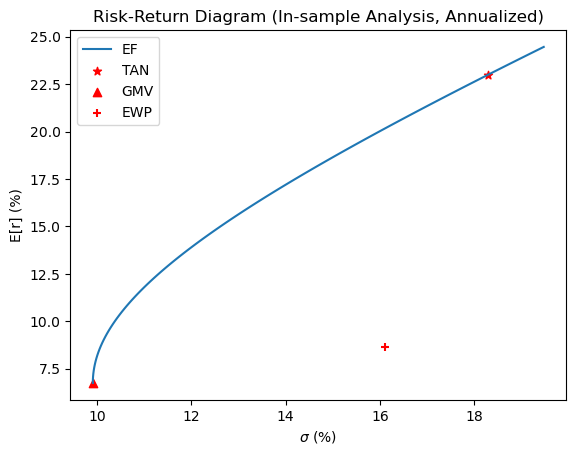

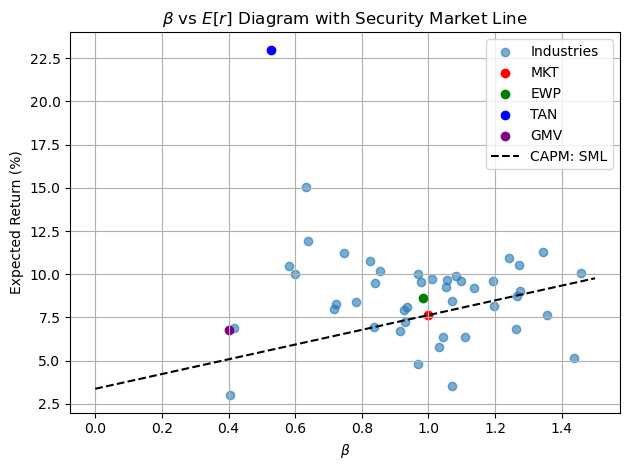

In [21]:
print('In-sample analysis')
print(industries.shape)
print(industries.columns)
plot_evaluation_results_in_sample (industries)

1.3 Robust Portfolio Construction and Out-of-sample Analysis

In [22]:
# 1986-2010 train/2011-2015 test
data_train = industries.iloc[:301]
data_test = industries.iloc[301:]
print(data_train)

     Agric  Food   Soda  Beer  Smoke   Toys    Fun  Books  Hshld  Clths  ...  \
0     7.36  1.82  -1.76 -1.42   4.99   1.58   3.35  -1.34  -1.52   4.66  ...   
1    13.45  7.36  11.15  7.18  11.67  10.19   7.75  14.14  10.20   8.80  ...   
2     2.14  7.24  10.29  8.57  10.92   5.05   6.26   4.47   4.97   5.57  ...   
3     4.72 -1.09   3.92 -3.44   3.12   3.39   7.84  -1.66  -2.18  -3.30  ...   
4     0.59  8.06   7.46  5.88   9.67   2.67   5.42  10.47   4.12   9.29  ...   
..     ...   ...    ...   ...    ...    ...    ...    ...    ...    ...  ...   
296  -5.74  2.34   4.10  4.94   9.73  10.76  15.10  14.04   3.97  17.53  ...   
297  19.42  3.77   7.36  1.92   5.33   2.05  15.39   6.64   4.50   3.33  ...   
298   0.85 -2.61   0.96  2.00  -3.90   9.26   6.84  -1.78  -2.37   9.26  ...   
299  15.82  4.56   0.90  3.56   4.22   1.94  -1.31   8.43   5.78   1.07  ...   
300   5.00 -1.93   1.85 -3.63  -3.30  -6.73   3.58   2.79  -1.01  -3.33  ...   

     BusSv  Comps  Chips  LabEq  Paper 

In [23]:
def estimate_beta_shrinkage(industry_excess, mkt_excess):
    """
    Returns shrinkage beta vector for 43 industries.
    beta_shrink = 0.5 * beta_grand_avg + 0.5 * beta_sample
    """
    beta_list = []
    for i in range(industry_excess.shape[1]):
        y = industry_excess.iloc[:, i]
        x = mkt_excess
        
        df = pd.concat([y, x], axis=1).dropna()
        y_aligned = df.iloc[:, 0]
        x_aligned = df.iloc[:, 1]

        X = sm.add_constant(x_aligned)  
        model = sm.OLS(y_aligned, X).fit()  
        beta_list.append(model.params.iloc[1]) 
    
    beta_sample = np.array(beta_list)  
    beta_grand_avg = np.mean(beta_sample) * np.ones_like(beta_sample) 
    beta_shrink = 0.5 * beta_grand_avg + 0.5 * beta_sample
    
    return beta_shrink


In [24]:
def estimate_mu_CAPM(beta_shrink, mkt_excess):
    """
    Returns expected return vector implied by CAPM with shrinkage beta.
    μ_i = rf + β_i × (E[r_mkt] - rf)
    """
    rf_mean = rf.loc[mkt_excess.index].mean() 
    mkt_mean = mkt_excess.mean()
    market_premium = mkt_mean - rf_mean
    mu_CAPM = rf_mean + beta_shrink * market_premium
    
    return mu_CAPM


In [25]:
def estimate_Vshrink(industry_excess):
    """
    Shrinkage covariance estimator:
    Vshrink = 0.3 * V_CC + 0.7 * V_sample
    """
    V_sample = industry_excess.cov()


    std_devs = np.sqrt(np.diag(V_sample))
    corr = industry_excess.corr()
    avg_corr = (corr.values[np.triu_indices_from(corr, k=1)].mean())
    V_CC = pd.DataFrame(avg_corr, index=corr.index, columns=corr.columns)
    np.fill_diagonal(V_CC.values, 1.0)
    V_CC = V_CC.values * np.outer(std_devs, std_devs)
    V_CC = pd.DataFrame(V_CC, index=corr.index, columns=corr.columns)

    V_shrink = 0.3 * V_CC + 0.7 * V_sample
    return V_shrink


In [26]:
mkt_excess_train = mkt_excess.iloc[:301]
mkt_excess_test = mkt_excess.iloc[301:]
beta_shrink_train = estimate_beta_shrinkage(data_train, mkt_excess_train)
beta_shrink_test = estimate_beta_shrinkage(data_test , mkt_excess_test )

In [28]:
# Annual return
exp_mkt_outsample = mkt_excess_train.mean() * 12

# Annual standard deviation
std_mkt_outsample = mkt_excess_train.std() * np.sqrt(12)

# Sharpe ratio for the market
sharpe_mkt_outsample = (mkt_excess_train.mean() / mkt_excess_train.std()) * np.sqrt(12)

In [29]:
def plot_evaluation_results_out_sample (data_train, data_test, mkt_excess_train):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are all evaluated on "data_test" 
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    
    
    ####
    # === Traditional Estimation ===
    # Obtain the special portfolios constructed from the training data
    mu_train = estimate_mu(data_train)
    V_train = estimate_V(data_train)
    beta_shrink_train = estimate_beta_shrinkage(data_train, mkt_excess_train)
    mu_CAPM_train = estimate_mu_CAPM(beta_shrink_train, mkt_excess_train)
    Vshrink_train = estimate_Vshrink(data_train)

    w_t_train = tangency(mu_train , V_train)
    w_g_train = gmv(V_train)
    w_t_robust_train = tangency(mu_CAPM_train, Vshrink_train)
    w_g_robust_train = gmv(Vshrink_train)
    
    print('******')
    print('The tangency portfolio constructed from the training data is: ', np.round(w_t_train,3))
    print('The global minimum variance portfolio constructed from the training data  is: ', np.round(w_g_train,3))
    print('******')
    
    #
    ####
    
    
    ####
    # Obtain the "true" special portfolios constructed from the test data
    
    mu_test = estimate_mu(data_test)
    V_test = estimate_V(data_test)
    beta_shrink_test = estimate_beta_shrinkage(data_test, mkt_excess_test)
    mu_CAPM_test = estimate_mu_CAPM(beta_shrink_test, mkt_excess_test)
    Vshrink_test = estimate_Vshrink(data_test)

    w_t_test = tangency(mu_test , V_test)
    w_g_test = gmv(V_test)
    w_t_robust_test = tangency(mu_CAPM_test, Vshrink_test)
    w_g_robust_test = gmv(Vshrink_test)
    
    print('******')
    print('The tangency portfolio constructed from the testing data is: ', np.round(w_t_test,3))
    print('The global minimum variance portfolio constructed from the testing data  is: ', np.round(w_g_test,3))
    print('******')
    
    w_e = ewp(data_train.shape[1]) # NB: the EWP portfolio is actually independent of the historical return


    

    #
    ####

    ####
    # Calculate the return for each portfolio
    ewp_return = data_test @ w_e
    tan_return = data_test @ w_t_train
    gmv_return = data_test @ w_g_train
    tan_return_robust = data_test @ w_t_robust_train
    gmv_return_robust = data_test @ w_g_robust_train

    # Calculate the expected return, standard deviation, and Sharpe ratio for each portfolio
    exp_ewp = ewp_return.mean() * 12
    std_ewp = ewp_return.std() * np.sqrt(12)
    sharpe_ewp = ((ewp_return - rf).mean() / ewp_return.std()) * np.sqrt(12)

    exp_tan = tan_return.mean() * 12
    std_tan = tan_return.std() * np.sqrt(12)
    sharpe_tan = ((tan_return - rf).mean() / tan_return.std()) * np.sqrt(12)

    exp_gmv = gmv_return.mean() * 12
    std_gmv = gmv_return.std() * np.sqrt(12)
    sharpe_gmv = ((gmv_return - rf).mean() / gmv_return.std()) * np.sqrt(12)

    exp_tan_robust = tan_return_robust.mean() * 12
    std_tan_robust = tan_return_robust.std() * np.sqrt(12)
    sharpe_tan_robust = ((tan_return_robust - rf).mean() / tan_return_robust.std()) * np.sqrt(12)

    exp_gmv_robust = gmv_return_robust.mean() * 12
    std_gmv_robust = gmv_return_robust.std() * np.sqrt(12)
    sharpe_gmv_robust = ((gmv_return_robust - rf).mean() / gmv_return_robust.std()) * np.sqrt(12)

    # Summary for each portfolio
    performance_data = {
    'MKT': [exp_mkt_outsample, std_mkt_outsample, sharpe_mkt_outsample],
    'EWP': [exp_ewp, std_ewp, sharpe_ewp],
    'TAN': [exp_tan, std_tan, sharpe_tan],
    'GMV': [exp_gmv, std_gmv, sharpe_gmv],
    'TAN-robust': [exp_tan_robust, std_tan_robust, sharpe_tan_robust],
    'GMV-robust': [exp_gmv_robust, std_gmv_robust, sharpe_gmv_robust]
    }

    performance_df = pd.DataFrame(
        performance_data,
        index=['Expected Return (%)', 'Standard Deviation (%)', 'Sharpe Ratio']
    ).round(3)

    display(performance_df)
    ####
    
    
    plt.figure(figsize=(8, 4))
    
    ####
    # Evaluate the special portfolios on testing data

    # Plot the Tangency portfolio (TAN) constructed from test data
    plt.scatter( evaluate_portfolio_performance_on_data (w_t_test, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data (w_t_test, data_test)['Er']* 12, 
                marker='*', color = 'red',label = 'TAN (from test)')
    
    # Plot the Global minimum variance portfolio (GMV) from test data
    plt.scatter( evaluate_portfolio_performance_on_data (w_g_test, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data (w_g_test, data_test)['Er']* 12, 
                marker='^', color = 'red',label = 'GMV (from test)')
    
    # Plot the Tangency portfolio (TAN) from train data
    plt.scatter( evaluate_portfolio_performance_on_data (w_t_train, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data (w_t_train, data_test)['Er']* 12, 
                marker='*', color = 'black',label = 'TAN (from train)')
    
    # Plot the Global minimum variance portfolio (GMV) from train data
    plt.scatter( evaluate_portfolio_performance_on_data (w_g_train, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data (w_g_train, data_test)['Er']* 12, 
                marker='^', color = 'black',label = 'GMV (from train)')
    
    # Plot the Wqually weighted portfolio (EWP)
    plt.scatter( evaluate_portfolio_performance_on_data (w_e, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data (w_e, data_test)['Er']* 12, 
                marker='+', color = 'red',label = 'EWP')

    # Plot the TAN-Robust portfolio from train data
    plt.scatter(  evaluate_portfolio_performance_on_data(w_t_robust_train, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data(w_t_robust_train, data_test)['Er']*12, 
                marker='*', color='green', label='TAN-robust (from train)')

    # Plot the GMV-Robust portfolio from train data
    plt.scatter(  evaluate_portfolio_performance_on_data(w_g_robust_train, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data(w_g_robust_train, data_test)['Er']*12, 
                marker='^', color='green', label='GMV-robust (from train)')

    # Plot the TAN-Robust portfolio from test data
    plt.scatter(  evaluate_portfolio_performance_on_data(w_t_robust_test, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data(w_t_robust_test, data_test)['Er']*12, 
                marker='*', color='blue', label='TAN-robust (from test)')

    # Plot the GMV-Robust portfolio from test data
    plt.scatter(  evaluate_portfolio_performance_on_data(w_g_robust_test, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data(w_g_robust_test, data_test)['Er']*12, 
                marker='^', color='blue', label='GMV-robust (from test)')
    #
    ####
    
    
    ####
    # The "True" EF is based on portfolios both constructed and evaluated on the TEST data
    sigma_true_range, Er_true_range = get_EF_on_data (w_t_test, w_g_test, data_test)
    plt.plot(sigma_true_range* np.sqrt(12), Er_true_range* 12, label = 'True EF')
    #
    ####

    ####
    # The "Estimated" EF is based on portfolios both constructed and evaluated on the TRAINING data
    # (Uncomment/comment if needed)
    sigma_estimate_range, Er_estimate_range = get_EF_on_data (w_t_train, w_g_train, data_train)
    plt.plot(sigma_estimate_range* np.sqrt(12), Er_estimate_range* 12, 'k--', label = 'Estimated EF')
    #
    ####
    
    ####
    # The "Realized" EF is based on portfolios constructed from TRAINING data but evaluated on TEST data
    sigma_realized_range, Er_realized_range = get_EF_on_data (w_t_train, w_g_train, data_test)
    plt.plot(sigma_realized_range* np.sqrt(12), Er_realized_range* 12, '--', label = 'Realized EF')
    #
    
    ####

    plt.legend()
    plt.title('Risk-Return Diagram (Out-of-sample Analysis), Annualized')
    plt.xlabel('$\\sigma$ (%)')
    plt.ylabel('E[r] (%)')
    
    plt.show()

Out-of-sample analysis
******
The tangency portfolio constructed from the training data is:  [-0.095  0.15   0.122  0.074  0.304 -0.417  0.295 -0.322 -0.162 -0.165
 -0.055  0.385  0.133 -0.185  0.221 -0.061 -0.032 -0.106 -0.406 -0.039
  0.107  0.417 -0.036 -0.18  -0.158  0.342 -0.047  0.461  0.056  0.332
  0.363 -0.429 -0.356  0.329 -0.165  0.249 -0.068  0.079  0.079  0.319
 -0.863  0.475  0.055]
The global minimum variance portfolio constructed from the training data  is:  [ 0.087  0.042  0.01  -0.02  -0.025 -0.003 -0.038  0.096  0.207 -0.084
 -0.051  0.093 -0.001 -0.218 -0.08   0.007 -0.069 -0.173 -0.062  0.081
 -0.016 -0.143 -0.072 -0.153 -0.011  0.099  0.058  0.014 -0.009  0.151
  0.417  0.095 -0.044 -0.103  0.111  0.053 -0.03   0.162  0.105  0.22
  0.031  0.203  0.063]
******
******
The tangency portfolio constructed from the testing data is:  [ 1.740e-01  5.050e-01 -9.130e-01  2.270e-01  3.240e-01  1.900e-02
 -3.910e-01 -1.690e-01 -3.760e-01 -2.430e-01 -2.200e-01 -6.410e-01
 -6.1

,MKT,EWP,TAN,GMV,TAN-robust,GMV-robust
Expected Return (%),6.795,9.775,12.817,10.332,13.420,13.384
Standard Deviation (%),16.110,13.592,14.806,10.443,9.332,9.540
Sharpe Ratio,0.422,0.718,0.864,0.987,1.436,1.401


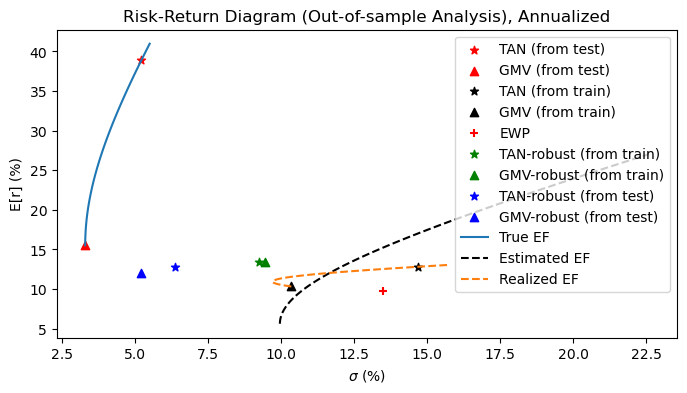

In [30]:
## Out-of-sample Analysis
print('Out-of-sample analysis')
plot_evaluation_results_out_sample (data_train, data_test, mkt_excess_train)

2 The Data Challenge

In [31]:
# 2005-2015 train/2011-2015 test
data_train_explore = industries.iloc[229:]
data_test_explore = industries.iloc[301:]
print(data_train_explore)

     Agric  Food  Soda  Beer  Smoke   Toys    Fun  Books  Hshld  Clths  ...  \
229   2.69 -1.22 -0.48  1.30   2.96  -0.41  -1.34  -0.19  -0.23   1.83  ...   
230   0.55 -1.50 -0.52 -1.20   0.10  -6.46   0.02  -1.59  -0.81  -1.44  ...   
231  -1.52 -0.37  1.10  1.98  -1.55 -11.71  -3.89  -3.37  -3.02  -7.57  ...   
232   4.49  1.50  3.55  2.17   2.94   3.09   4.19  -1.11   1.39   6.42  ...   
233  -0.83 -2.54  1.90 -4.16  -2.57   1.52  -1.55  -0.88  -2.72   5.73  ...   
..     ...   ...   ...   ...    ...    ...    ...    ...    ...    ...  ...   
355  -4.59 -4.22 -4.57 -3.12  -4.06  -4.83  -7.79  -8.76  -6.94  -3.86  ...   
356 -11.16 -1.73  2.15  2.58   2.37  -5.42 -10.75  -5.65  -0.53   1.18  ...   
357   8.63  5.44  5.77  8.06  10.90  11.86  15.14  12.44   5.81   0.98  ...   
358   1.87 -1.59  2.36 -0.71  -3.00  -2.23  -0.08  -0.06  -1.10  -1.08  ...   
359   2.06  2.97  0.41  0.30   1.59  -2.42  -1.56  -5.95   1.86  -4.38  ...   

     BusSv  Comps  Chips  LabEq  Paper  Boxes  Tran

In [32]:
# Using beta to construct market weights
beta_vector = summary['Beta'].iloc[229:].copy()

# Weights sum up to 1
assets = data_train_explore.columns  
print(assets)
beta_vector = summary.loc[assets, 'Beta'].copy()  
w_mkt_train = beta_vector / beta_vector.sum()

# check
print("Sum of weights:", w_mkt_train.sum())
print(w_mkt_train.head())

mu_CAPM_train = estimate_mu_CAPM(beta_shrink_train, mkt_excess_train)
Vshrink_train = estimate_Vshrink(data_train)

Index(['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books',
       'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
       'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero',
       'Ships', 'Guns', 'Gold', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm',
       'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans',
       'Whlsl', 'Rtail', 'Meals'],
      dtype='object')
Sum of weights: 0.9999999999999999
Agric    0.018478
Food     0.014188
Soda     0.019521
Beer     0.015120
Smoke    0.014969
Name: Beta, dtype: float64


In [33]:
rf_test = rf.iloc[301:]

mkt_excess_explore_train = mkt_excess.iloc[229:301]
mkt_excess_explore_test = mkt_excess.iloc[301:]
beta_shrink_explore_train = estimate_beta_shrinkage(data_train_explore, mkt_excess_explore_train)
#beta_shrink_explore_test = estimate_beta_shrinkage(data_test_explore, mkt_excess_explore_test)

mu_CAPM_explore_train = estimate_mu_CAPM(beta_shrink_explore_train, mkt_excess_explore_train)

Vshrink_explore_train = estimate_Vshrink(data_train_explore)


w_t_robust_explore_train = tangency(mu_CAPM_explore_train, Vshrink_explore_train)

# Annual return
exp_mkt_explore = mkt_excess_explore_train.mean() * 12

# Annual standard deviation
std_mkt_explore = mkt_excess_explore_train.std() * np.sqrt(12)

# Sharpe ratio for the market
sharpe_mkt_explore = (mkt_excess_explore_train.mean() / mkt_excess_explore_train.std()) * np.sqrt(12)


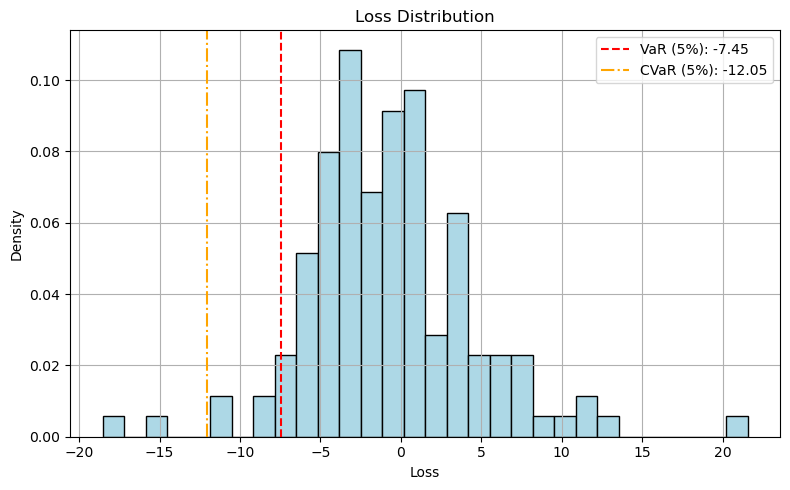

In [34]:
import matplotlib.pyplot as plt

w0 = w_mkt_train  # initial guess 
# Plot loss distribution
portfolio_returns = data_train_explore @ w0
losses = -portfolio_returns
sorted_losses = np.sort(losses)

alpha = 0.05
var_index = int(alpha * len(sorted_losses))
VaR = sorted_losses[var_index]
CVaR = sorted_losses[:var_index].mean()

plt.figure(figsize=(8, 5))
plt.hist(losses, bins=30, density=True, color='lightblue', edgecolor='black')
plt.axvline(VaR, color='red', linestyle='--', label=f'VaR (5%): {VaR:.2f}')
plt.axvline(CVaR, color='orange', linestyle='-.', label=f'CVaR (5%): {CVaR:.2f}')
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
def cvar_objective_method(w, data, alpha=0.05):
    portfolio_returns = data @ w 
    losses = -portfolio_returns
    sorted_losses = np.sort(losses)
    var_index = int(alpha * len(sorted_losses))
    VaR = sorted_losses[var_index]
    es = np.mean(sorted_losses[:var_index])  # CVaR

    return es

from scipy.optimize import minimize
n_assets = data_train_explore.shape[1]
mu_train = estimate_mu(data_train_explore) # monthly
exp_mkt_explore = mkt_excess_explore_train.mean() * 12
target_return = exp_mkt_explore / 12  # return not lower than avg EWP and covert to monthly

sigma_max = 3.5 # monthly volatility <= 5%
V_train_cvar = estimate_V(data_train_explore)

constraints = constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # sum of weights = 1
    {"type": "ineq", "fun": lambda w: w @ mu_train - target_return},  # E[r] ≥ target
    {"type": "ineq", "fun": lambda w: sigma_max - np.sqrt(w.T @ V_train_cvar @ w)}
]
bounds = [(0, 1)] * n_assets  # optional: long-only
print("w0 length:", len(w0))
print("n_assets:", n_assets)
print("Summary index:", summary.index.tolist()[:5])
print("Data column names:", data_train_explore.columns.tolist()[:5])
res_train = minimize(cvar_objective_method, w0, args=(data_train_explore,), bounds=bounds, constraints=constraints) 
w_cvar_train = res_train.x

print(w_cvar_train)
# Convert to DataFrame
w_cvar_df = pd.DataFrame({'Asset': assets, 'Weight': w_cvar_train})

# Export as CSV
w_cvar_df.to_csv('cvar_weights.csv', index=False, encoding='utf-8-sig')

print("Optimizer success:", res_train.success)
print("Message:", res_train.message)

w0 length: 43
n_assets: 43
Summary index: ['Agric', 'Food', 'Soda', 'Beer', 'Smoke']
Data column names: ['Agric', 'Food', 'Soda', 'Beer', 'Smoke']
[4.44539275e-02 3.40036781e-13 7.16751451e-03 1.86451738e-01
 1.52928224e-01 6.59930375e-14 0.00000000e+00 0.00000000e+00
 2.06756098e-13 1.27757200e-01 1.11428221e-13 2.58681557e-13
 9.79418558e-14 3.37821093e-13 0.00000000e+00 2.84021084e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.65875597e-13
 0.00000000e+00 0.00000000e+00 2.19405552e-02 1.26092144e-13
 0.00000000e+00 3.73459694e-13 1.72094080e-02 0.00000000e+00
 0.00000000e+00 8.64763072e-14 1.85517009e-01 6.35427088e-14
 1.20415132e-13 6.22435541e-14 5.09492524e-13 0.00000000e+00
 1.12889043e-13 0.00000000e+00 1.08338523e-13 1.90639794e-03
 1.36429579e-13 2.26265918e-01 1.55148099e-13]
Optimizer success: True
Message: Optimization terminated successfully


In [36]:
def plot_evaluation_results_out_sample (data_train, data_test, mkt_excess_train, mkt_excess_test, w_cvar):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are all evaluated on "data_test" 
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    
        ####
    # === Traditional Estimation ===
    # Obtain the special portfolios constructed from the training data
    mu_train = estimate_mu(data_train)
    V_train = estimate_V(data_train)
    beta_shrink_train = estimate_beta_shrinkage(data_train, mkt_excess_train)
    mu_CAPM_train = estimate_mu_CAPM(beta_shrink_train, mkt_excess_train)
    Vshrink_train = estimate_Vshrink(data_train)

    w_t_train = tangency(mu_train , V_train)
    w_g_train = gmv(V_train)
    w_t_robust_train = tangency(mu_CAPM_train, Vshrink_train)
    w_g_robust_train = gmv(Vshrink_train)
    
    print('******')
    print('The tangency portfolio constructed from the training data is: ', np.round(w_t_train,3))
    print('The global minimum variance portfolio constructed from the training data  is: ', np.round(w_g_train,3))
    print('******')
    
    #
    ####
    ####
    # Obtain the "true" special portfolios constructed from the test data
    
    mu_test = estimate_mu(data_test)
    V_test = estimate_V(data_test)
    beta_shrink_test = estimate_beta_shrinkage(data_test, mkt_excess_test)
    mu_CAPM_test = estimate_mu_CAPM(beta_shrink_test, mkt_excess_test)
    Vshrink_test = estimate_Vshrink(data_test)

    w_t_test = tangency(mu_test , V_test)
    w_g_test = gmv(V_test)
    w_t_robust_test = tangency(mu_CAPM_test, Vshrink_test)
    w_g_robust_test = gmv(Vshrink_test)
    
    print('******')
    print('The tangency portfolio constructed from the testing data is: ', np.round(w_t_test,3))
    print('The global minimum variance portfolio constructed from the testing data  is: ', np.round(w_g_test,3))
    print('******')
    
    w_e = ewp(data_train.shape[1]) # NB: the EWP portfolio is actually independent of the historical return


    

    #
    ####

    ####
    # Calculate the return for each portfolio
    ewp_return = data_test @ w_e
    tan_return = data_test @ w_t_train
    gmv_return = data_test @ w_g_train
    tan_return_robust = data_test @ w_t_robust_train
    gmv_return_robust = data_test @ w_g_robust_train
    cvar_return = data_test @ w_cvar

    # Calculate the expected return, standard deviation, and Sharpe ratio for each portfolio
    exp_ewp = ewp_return.mean() * 12
    std_ewp = ewp_return.std() * np.sqrt(12)
    sharpe_ewp = ((ewp_return - rf_test).mean() / ewp_return.std()) * np.sqrt(12)

    exp_tan = tan_return.mean() * 12
    std_tan = tan_return.std() * np.sqrt(12)
    sharpe_tan = ((tan_return - rf_test).mean() / tan_return.std()) * np.sqrt(12)

    exp_gmv = gmv_return.mean() * 12
    std_gmv = gmv_return.std() * np.sqrt(12)
    sharpe_gmv = ((gmv_return - rf_test).mean() / gmv_return.std()) * np.sqrt(12)

    exp_tan_robust = tan_return_robust.mean() * 12
    std_tan_robust = tan_return_robust.std() * np.sqrt(12)
    sharpe_tan_robust = ((tan_return_robust - rf_test).mean() / tan_return_robust.std()) * np.sqrt(12)

    exp_gmv_robust = gmv_return_robust.mean() * 12
    std_gmv_robust = gmv_return_robust.std() * np.sqrt(12)
    sharpe_gmv_robust = ((gmv_return_robust - rf_test).mean() / gmv_return_robust.std()) * np.sqrt(12)

    exp_cvar = cvar_return.mean() * 12
    std_cvar = cvar_return.std() * np.sqrt(12)
    sharpe_cvar = ((cvar_return - rf_test).mean() / cvar_return.std()) * np.sqrt(12)

    # Summary for each portfolio
    performance_data = {
    'MKT': [exp_mkt_explore, std_mkt_explore, sharpe_mkt_explore],
    'EWP': [exp_ewp, std_ewp, sharpe_ewp],
    'TAN': [exp_tan, std_tan, sharpe_tan],
    'GMV': [exp_gmv, std_gmv, sharpe_gmv],
    'TAN-robust': [exp_tan_robust, std_tan_robust, sharpe_tan_robust],
    'GMV-robust': [exp_gmv_robust, std_gmv_robust, sharpe_gmv_robust],
    'CVaR-Min': [exp_cvar, std_cvar, sharpe_cvar]
    }

    performance_df = pd.DataFrame(
        performance_data,
        index=['Expected Return (%)', 'Standard Deviation (%)', 'Sharpe Ratio']
    ).round(3)

    display(performance_df)
    ####
    
    
    plt.figure(figsize=(8, 4))
    
    ####
    # Evaluate the special portfolios on testing data

    # Plot the Tangency portfolio (TAN) constructed from test data
    # plt.scatter( evaluate_portfolio_performance_on_data (w_t_test, data_test)['sigma']* np.sqrt(12), 
    #             evaluate_portfolio_performance_on_data (w_t_test, data_test)['Er']* 12, 
    #             marker='*', color = 'red',label = 'TAN (from test)')
    
    # Plot the Global minimum variance portfolio (GMV) from test data
    # plt.scatter( evaluate_portfolio_performance_on_data (w_g_test, data_test)['sigma']* np.sqrt(12), 
    #             evaluate_portfolio_performance_on_data (w_g_test, data_test)['Er']* 12, 
    #             marker='^', color = 'red',label = 'GMV (from test)')
    
    # Plot the Tangency portfolio (TAN) from train data
    plt.scatter( evaluate_portfolio_performance_on_data (w_t_train, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data (w_t_train, data_test)['Er']* 12, 
                marker='*', color = 'black',label = 'TAN')
    
    # Plot the Global minimum variance portfolio (GMV) from train data
    plt.scatter( evaluate_portfolio_performance_on_data (w_g_train, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data (w_g_train, data_test)['Er']* 12, 
                marker='^', color = 'black',label = 'GMV')
    
    # Plot the Wqually weighted portfolio (EWP)
    plt.scatter( evaluate_portfolio_performance_on_data (w_e, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data (w_e, data_test)['Er']* 12, 
                marker='+', color = 'red',label = 'EWP')

    # Plot the TAN-Robust portfolio from train data
    plt.scatter(  evaluate_portfolio_performance_on_data(w_t_robust_train, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data(w_t_robust_train, data_test)['Er']*12, 
                marker='*', color='green', label='TAN-robust')

    # Plot the GMV-Robust portfolio from train data
    plt.scatter(  evaluate_portfolio_performance_on_data(w_g_robust_train, data_test)['sigma']* np.sqrt(12), 
                evaluate_portfolio_performance_on_data(w_g_robust_train, data_test)['Er']*12, 
                marker='^', color='green', label='GMV-robust')

    # Plot the TAN-Robust portfolio from test data
    # plt.scatter(  evaluate_portfolio_performance_on_data(w_t_robust_test, data_test)['sigma']* np.sqrt(12), 
    #             evaluate_portfolio_performance_on_data(w_t_robust_test, data_test)['Er']*12, 
    #             marker='*', color='blue', label='TAN-robust (from test)')

    # Plot the GMV-Robust portfolio from test data
    # plt.scatter(  evaluate_portfolio_performance_on_data(w_g_robust_test, data_test)['sigma']* np.sqrt(12), 
    #             evaluate_portfolio_performance_on_data(w_g_robust_test, data_test)['Er']*12, 
    #             marker='^', color='blue', label='GMV-robust (from test)')

    # Plot the CVaR-minimizing portfolio from train data
    plt.scatter(
        evaluate_portfolio_performance_on_data(w_cvar, data_test)['sigma'] * np.sqrt(12),
        evaluate_portfolio_performance_on_data(w_cvar, data_test)['Er'] * 12,
        marker='x', color='orange', label='CVaR-Min')
    ####
    
    
    ####
    # The "True" EF is based on portfolios both constructed and evaluated on the TEST data
    sigma_true_range, Er_true_range = get_EF_on_data (w_t_test, w_g_test, data_test)
    plt.plot(sigma_true_range* np.sqrt(12), Er_true_range* 12, label = 'True EF')
    #
    ####

    ####
    # The "Estimated" EF is based on portfolios both constructed and evaluated on the TRAINING data
    # (Uncomment/comment if needed)
    sigma_estimate_range, Er_estimate_range = get_EF_on_data (w_t_train, w_g_train, data_train)
    plt.plot(sigma_estimate_range* np.sqrt(12), Er_estimate_range* 12, 'k--', label = 'Estimated EF')
    #
    ####
    
    ####
    # The "Realized" EF is based on portfolios constructed from TRAINING data but evaluated on TEST data
    sigma_realized_range, Er_realized_range = get_EF_on_data (w_t_train, w_g_train, data_test)
    plt.plot(sigma_realized_range* np.sqrt(12), Er_realized_range* 12, '--', label = 'Realized EF')
    #
    ####
    ####
    ####

    plt.legend()
    plt.title('Risk-Return Diagram (Out-of-sample Analysis), Annualized')
    plt.xlabel('$\\sigma$ (%)')
    plt.ylabel('E[r] (%)')
    
    plt.show()

Out-of-sample analysis-optimisation
******
The tangency portfolio constructed from the training data is:  [ 0.078  0.304 -0.127  0.255  0.342 -0.424 -0.352 -0.298 -1.081  0.211
  0.205 -0.397  0.485 -0.501  0.48   0.1    0.219 -0.651 -0.336 -0.04
  0.729 -0.554  0.037  0.21   0.117  0.288 -0.033  0.134 -0.114  0.268
 -0.019 -0.404 -0.449  0.505 -0.238 -0.22   0.691 -0.3    0.312  0.364
  0.473  0.122  0.607]
The global minimum variance portfolio constructed from the training data  is:  [ 0.026  0.401  0.115  0.023 -0.046 -0.144 -0.087  0.044 -0.005  0.089
  0.157 -0.001 -0.127 -0.008 -0.103 -0.093 -0.032 -0.045 -0.122  0.072
 -0.081  0.063 -0.058 -0.077 -0.089  0.105  0.084 -0.014 -0.009  0.105
  0.207 -0.074 -0.036  0.048  0.038 -0.172 -0.039  0.015  0.036  0.322
  0.261  0.233  0.024]
******
******
The tangency portfolio constructed from the testing data is:  [ 1.740e-01  5.050e-01 -9.130e-01  2.270e-01  3.240e-01  1.900e-02
 -3.910e-01 -1.690e-01 -3.760e-01 -2.430e-01 -2.200e-01 -6.

,MKT,EWP,TAN,GMV,TAN-robust,GMV-robust,CVaR-Min
Expected Return (%),3.410,9.775,49.889,11.227,14.452,14.453,15.260
Standard Deviation (%),16.873,13.592,15.774,7.274,7.701,7.835,9.587
Sharpe Ratio,0.202,0.718,3.162,1.541,1.874,1.842,1.590


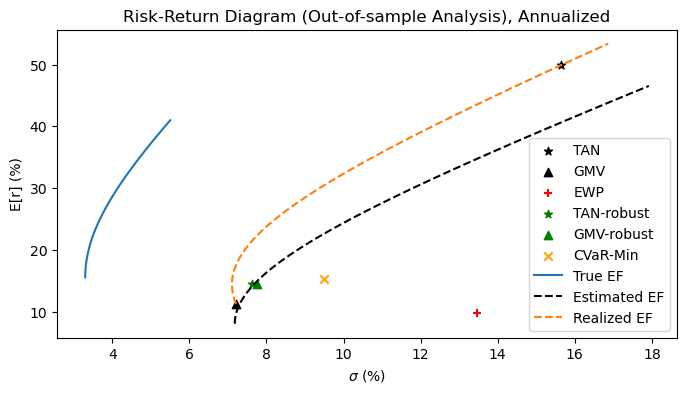

In [37]:
## Out-of-sample Analysis
print('Out-of-sample analysis-optimisation')
plot_evaluation_results_out_sample (data_train_explore, data_test_explore, mkt_excess_explore_train, mkt_excess_explore_test, w_cvar_train)

# LLM Implementation

In [1]:
pip install pandas numpy cvxpy openai

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
df = pd.read_csv('gp_data_1986_to_2015.csv')
df

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.56,7.92,2.38,-1.20,-0.86,5.55,2.14,3.91,...,0.78,-1.11,0.85,3.80,4.61,1.91,5.60,2.48,1.67,-0.09
1,198602,7.13,0.53,13.98,7.89,11.68,7.71,12.20,10.72,8.28,...,7.47,2.71,8.34,9.98,8.68,10.61,7.03,8.85,7.21,9.27
2,198603,4.88,0.60,2.74,7.84,10.89,9.17,11.52,5.65,6.86,...,4.96,-0.11,0.04,-1.15,4.18,5.61,3.22,7.41,9.11,6.42
3,198604,-1.31,0.52,5.24,-0.57,4.44,-2.92,3.64,3.91,8.36,...,3.33,3.87,3.55,2.69,-2.50,-0.93,-2.64,1.70,-0.70,3.86
4,198605,4.62,0.49,1.08,8.55,7.95,6.37,10.16,3.16,5.91,...,5.41,1.01,-0.75,2.51,6.66,5.07,0.70,5.52,11.95,4.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,201508,-6.04,0.00,-4.59,-4.22,-4.57,-3.12,-4.06,-4.83,-7.79,...,-5.40,-8.20,-5.53,-7.60,-5.98,-3.58,-6.36,-4.27,-5.42,-6.48
356,201509,-3.07,0.00,-11.16,-1.73,2.15,2.58,2.37,-5.42,-10.75,...,-1.47,-2.35,-0.82,-4.79,-2.33,-4.97,-0.72,-6.00,-1.72,0.44
357,201510,7.75,0.00,8.63,5.44,5.77,8.06,10.90,11.86,15.14,...,11.41,5.87,8.88,7.56,10.25,9.78,6.47,5.17,4.53,5.05
358,201511,0.56,0.00,1.87,-1.59,2.36,-0.71,-3.00,-2.23,-0.08,...,2.11,-3.03,0.23,5.24,0.02,-0.32,-1.11,2.70,0.59,-1.01


In [3]:
Rf = df['RF'].values.copy()
for column in df.columns:
    if column in ['Month', 'Mkt-RF']:
        continue
    df[column] -= Rf

df.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.0,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
1,198602,7.13,0.0,13.45,7.36,11.15,7.18,11.67,10.19,7.75,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
2,198603,4.88,0.0,2.14,7.24,10.29,8.57,10.92,5.05,6.26,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
3,198604,-1.31,0.0,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
4,198605,4.62,0.0,0.59,8.06,7.46,5.88,9.67,2.67,5.42,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


In [4]:
df.columns = df.columns.str.strip()

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import cvxpy as cp
import logging
from openai import OpenAI

with open('api_key_2425Sem2.txt', 'r') as file:
    # Read the contents of the file into a string variable
    key = file.read()

client = OpenAI(api_key=key) 
# set up logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# tool 1: stats tool
def stats_tool(df):
    logger.info("Running stats_tool")
    # data verification
    if df.isnull().any().any():
        logger.error("Data contains missing values")
        raise ValueError("Data contains missing values")
    if not np.all(df.apply(lambda x: np.issubdtype(x.dtype, np.number))):
        logger.error("Data contains non-numeric values")
        raise ValueError("Data contains non-numeric values")
    
    # check abnormal value
    returns_range = df.abs().max().max()
    if returns_range > 10:  # if monthly return over 1000%, unreasonable
        logger.warning(f"Extreme returns detected: max abs value = {returns_range:.4f}")
    
    mean_returns = df.mean().to_numpy()
    std_devs = df.std().to_numpy()
    cov_matrix = df.cov().to_numpy()
    
    # regularization
    alpha = 0.2
    cov_matrix = (1 - alpha) * cov_matrix + alpha * np.eye(len(cov_matrix)) * np.trace(cov_matrix) / len(cov_matrix)
    
    # check positive definite
    eigenvalues = np.linalg.eigvals(cov_matrix)
    if np.any(eigenvalues <= 0):
        logger.warning("Covariance matrix not positive definite after regularization")
        cov_matrix += np.eye(len(cov_matrix)) * 1e-6 
    
    logger.info(f"Mean returns: min={mean_returns.min():.4f}, max={mean_returns.max():.4f}")
    logger.info(f"Cov matrix shape: {cov_matrix.shape}, trace={np.trace(cov_matrix):.4f}")
    return mean_returns, std_devs, cov_matrix

# tool 2: optimization methods
def sharpe_optimization(mean_returns, cov_matrix, risk_free_rate):
    logger.info("Running sharpe_optimization")
    n = len(mean_returns)

    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        portfolio_return = np.sum(mean_returns * weights) * 12
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))
        if portfolio_volatility < 1e-6:
            logger.warning("Portfolio volatility near zero")
            return np.inf
        return -(portfolio_return - risk_free_rate) / portfolio_volatility

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.ones(n) / n

    result = minimize(neg_sharpe_ratio,
                      initial_weights,
                      args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

    if not result.success:
        logger.error("Sharpe optimization failed: " + result.message)
        raise ValueError("Optimization failed")
    
    return result.x

def mvo_optimization(mean_returns, cov_matrix, risk_free_rate):
    logger.info("Running mvo_optimization")
    n = len(mean_returns)
    best_weights = None
    best_sharpe = -np.inf
    test_data = LLMAgent._global_state.get("test_data")
    
    if test_data is None:
        logger.error("Test data not available for MVO")
        return None
    
    for lambda_risk in np.logspace(-2, 2, 5):
        w = cp.Variable(n)
        objective = cp.Maximize(mean_returns @ w * 12 - lambda_risk / 2 * cp.quad_form(w, cov_matrix * 12))
        constraints = [cp.sum(w) == 1, w >= 0]
        prob = cp.Problem(objective, constraints)
        
        try:
            prob.solve(solver=cp.SCS, verbose=False)  # SCS solver is more stable
            if prob.status != cp.OPTIMAL:
                logger.warning(f"MVO lambda_risk={lambda_risk:.4f} failed: {prob.status}")
                continue
            weights = w.value
            if weights is None or np.any(np.isnan(weights)):
                logger.warning(f"MVO lambda_risk={lambda_risk:.4f} returned invalid weights")
                continue
            
            sharpe, _, _ = backtest_tool(weights, test_data, risk_free_rate)
            logger.info(f"MVO lambda_risk={lambda_risk:.4f}, Sharpe={sharpe:.4f}")
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_weights = weights.copy()
        except Exception as e:
            logger.warning(f"MVO lambda_risk={lambda_risk:.4f} failed: {str(e)}")
            continue
    
    if best_weights is None:
        logger.error("MVO failed to produce valid weights")
        return None
    
    logger.info(f"MVO best weights: min={best_weights.min():.4f}, max={best_weights.max():.4f}, sum={best_weights.sum():.4f}")
    return best_weights

def black_litterman_optimization(mean_returns, cov_matrix, risk_free_rate, tau=0.025, risk_aversion=1.0):
    logger.info("Running black_litterman_optimization")
    n = len(mean_returns)

    # define market_weights is equal weights
    market_weights = np.ones(n) / n 

    # prior market equalibrium pi
    pi = tau * cov_matrix @ market_weights

    adjusted_returns = pi

    w = cp.Variable(n)
    objective = cp.Maximize(adjusted_returns @ w * 12 - risk_aversion / 2 * cp.quad_form(w, cov_matrix* 12))
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.SCS, verbose=False)
        if prob.status != cp.OPTIMAL:
            logger.error(f"Black-Litterman failed: {prob.status}")
            return None
        weights = w.value
        if weights is None or np.any(np.isnan(weights)):
            logger.error("Black-Litterman returned invalid weights")
            return None
        logger.info(f"Black-Litterman weights: min={weights.min():.4f}, max={weights.max():.4f}, sum={weights.sum():.4f}")
        return weights
    except Exception as e:
        logger.error(f"Black-Litterman failed: {str(e)}")
        return None


def equal_weight_optimization(mean_returns, cov_matrix, risk_free_rate):
    logger.info("Running equal_weight_optimization")
    n = len(mean_returns)
    weights = np.ones(n) / n
    logger.info(f"Equal Weight weights: min={weights.min():.4f}, max={weights.max():.4f}, sum={weights.sum():.4f}")
    return weights

# tool 3: backtest tool
def backtest_tool(weights, test_data, risk_free_rate=0.0):
    logger.info("Running backtest_tool")
    try:
        portfolio_returns = test_data @ weights
        avg_return = portfolio_returns.mean() * 12
        volatility = portfolio_returns.std() * np.sqrt(12)
        if volatility < 1e-6:
            logger.warning("Portfolio volatility near zero")
            sharpe = 0.0
        else:
            sharpe = (avg_return - risk_free_rate) / volatility
        logger.info(f"Backtest results: Sharpe={sharpe:.4f}, Return={avg_return:.4f}, Volatility={volatility:.4f}")
        return sharpe, avg_return, volatility
    except Exception as e:
        logger.error(f"Backtest failed: {str(e)}")
        return 0.0, 0.0, 0.0

# tool 4: data-splitting tool
def split_data_tool(df, train_months=240, total_months=360):
    logger.info("Running split_data_tool")
    if len(df) < total_months:
        logger.error(f"Data has {len(df)} rows, expected {total_months}")
        raise ValueError(f"Data has {len(df)} rows, expected {total_months}")
    train_data = df.iloc[:train_months]
    test_data = df.iloc[train_months:total_months]
    logger.info(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")
    return train_data, test_data

# tool 5: reflection tool
def reflection_tool(results):
    logger.info("Running reflection_tool")
    prompt = """
    You are a financial analysis assistant. Below are the results of different portfolio optimization methods:
    {}
    Each result includes the method name, Sharpe ratio, return, volatility, and weights distribution.
    Your task is to select the method with the highest Sharpe ratio and provide a concise recommendation to proceed with that method.
    Return the selected method name and a brief justification in the format:
    "Method: <name>, Justification: <reason>"
    """
    results_str = "\n".join([
        f"Method: {r['method']}, Sharpe Ratio: {r['sharpe']:.2f}, Return: {r['return']:.2f}, Volatility: {r['volatility']:.2f}, "
        f"Weights (min/max/sum): {r['weights'].min():.4f}/{r['weights'].max():.4f}/{r['weights'].sum():.4f}"
        for r in results
    ])
    prompt = prompt.format(results_str)
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a financial analysis assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=100
        )
        logger.info(f"Reflection response: {response.choices[0].message.content}")
        return response.choices[0].message.content
    except Exception as e:
        logger.error(f"Reflection failed: {str(e)}")
        # backup: choose the highest sharpe ratio
        if results:
            best = max(results, key=lambda x: x["sharpe"])
            return f"Method: {best['method']}, Justification: Highest Sharpe ratio ({best['sharpe']:.2f})"
        return "Method: None, Justification: No valid results"

# tools dictionary
tools = {
    "stats_tool": {
        "function": stats_tool,
        "description": "Calculates mean returns, standard deviations, and covariance matrix for the data."
    },
    "optimization_tool": {
        "function": None,  # dynamic 
        "description": "Generates optimal weights using various portfolio optimization methods."
    },
    "backtest_tool": {
        "function": backtest_tool,
        "description": "Tests the performance of weights on historical data, calculating Sharpe ratio, expected return, and volatility."
    },
    "split_data_tool": {
        "function": split_data_tool,
        "description": "Splits data into training and testing sets for validation."
    }
}

# LLM Agent
class LLMAgent:
    _global_state = {}

    def __init__(self, tools, df, risk_free_rate=0.0):
        self.tools = tools
        self.df = df
        self.risk_free_rate = risk_free_rate
        self.state = {}
        logger.info(f"Initialized LLMAgent with risk_free_rate={risk_free_rate:.4f}")

    def choose_tool(self, task):
        logger.info(f"Choosing tool for task: {task}")
        tool_descriptions = "\n".join([f"{name}: {info['description']}" for name, info in self.tools.items()])
        prompt = f"""
        You are an intelligent agent tasked with analyzing financial data. Your current task is: "{task}".
        Below are the available tools and their descriptions:
        {tool_descriptions}
        Choose the most appropriate tool for the task and return only the tool name (e.g., "stats_tool").
        """
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are an intelligent financial analysis agent."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=50
            )
            tool_name = response.choices[0].message.content.strip()
            logger.info(f"Selected tool: {tool_name}")
            return tool_name
        except Exception as e:
            logger.error(f"Tool selection failed: {str(e)}")
            raise

    def run(self):
        logger.info("Starting LLMAgent run")
        # step 1: ask for basic statistical data
        task = "calculate statistics of the data for the 43 stocks"
        tool_name = self.choose_tool(task)
        print(f"Chosen tool for '{task}': {tool_name}")
        try:
            mean_returns, std_devs, cov_matrix = self.tools[tool_name]["function"](self.df.iloc[:, 3:])
            self.state["mean_returns"] = mean_returns
            self.state["cov_matrix"] = cov_matrix
            self.state["std"] = std_devs
        except Exception as e:
            logger.error(f"Stats calculation failed: {str(e)}")
            raise

        # step 2：split the data
        task = "split data into training and testing sets"
        tool_name = self.choose_tool(task)
        print(f"Chosen tool for '{task}': {tool_name}")
        try:
            train_data, test_data = self.tools[tool_name]["function"](self.df.iloc[:, 3:])
            self.state["train_data"] = train_data
            self.state["test_data"] = test_data
            LLMAgent._global_state["test_data"] = test_data
        except Exception as e:
            logger.error(f"Data splitting failed: {str(e)}")
            raise

        # step 3：traverse all optimization methods
        optimization_methods = [
            ("Sharpe Optimization", sharpe_optimization),
            ("Mean-Variance Optimization", mvo_optimization),
            ("Black-Litterman", black_litterman_optimization),
            ("Equal Weight", equal_weight_optimization)
        ]
        
        results = []
        
        for method_name, method_func in optimization_methods:
            task = "optimize weights using portfolio optimization"
            tool_name = self.choose_tool(task)
            print(f"Chosen tool for '{task}' ({method_name}): {tool_name}")
            
            try:
                weights = method_func(self.state["mean_returns"], self.state["cov_matrix"], self.risk_free_rate)
                if weights is None or np.any(np.isnan(weights)):
                    logger.error(f"{method_name} produced invalid weights")
                    print(f"{method_name} failed: Invalid weights")
                    continue
                
                # step 4：backtest
                task = "backtest weights on test data"
                tool_name = self.choose_tool(task)
                print(f"Chosen tool for '{task}' ({method_name}): {tool_name}")
                sharpe, avg_return, volatility = self.tools[tool_name]["function"](weights, self.state["test_data"], self.risk_free_rate)
                
                results.append({
                    "method": method_name,
                    "weights": weights,
                    "sharpe": sharpe,
                    "return": avg_return,
                    "volatility": volatility
                })
                print(f"{method_name}:")
                print(f"  Sharpe Ratio = {sharpe:.2f}")
                print(f"  Return = {avg_return:.2f}")
                print(f"  Volatility = {volatility:.2f}")
                print(f"  Weights (min/max/sum): {weights.min():.4f}/{weights.max():.4f}/{weights.sum():.4f}")
            except Exception as e:
                logger.error(f"{method_name} failed: {str(e)}")
                print(f"{method_name} failed: {str(e)}")
        
        # step 5：LLM chooses the best performance
        if results:
            reflection = reflection_tool(results)
            print(f"Reflection: {reflection}")
            
            # analyze LLM response
            try:
                selected_method = reflection.split(",")[0].split(":")[1].strip()
                for result in results:
                    if result["method"] == selected_method:
                        self.state["weights"] = result["weights"]
                        self.state["sharpe"] = result["sharpe"]
                        break
                else:
                    best_result = max(results, key=lambda x: x["sharpe"])
                    self.state["weights"] = best_result["weights"]
                    self.state["sharpe"] = best_result["sharpe"]
                    print(f"Warning: LLM selected invalid method, defaulting to {best_result['method']}")
            except Exception as e:
                logger.error(f"Failed to parse LLM reflection: {str(e)}")
                best_result = max(results, key=lambda x: x["sharpe"])
                self.state["weights"] = best_result["weights"]
                self.state["sharpe"] = best_result["sharpe"]
                print(f"Warning: LLM reflection parsing failed, defaulting to {best_result['method']}")
        else:
            logger.error("No valid results, returning equal weights")
            print("No valid results, returning equal weights")
            self.state["weights"] = np.ones(len(self.state["mean_returns"])) / len(self.state["mean_returns"])
            self.state["sharpe"] = 0.0
        
        return self.state["weights"]

if __name__ == "__main__":
    risk_free_rate = df["RF"].mean() if "RF" in df else 0.0
    agent = LLMAgent(tools, df, risk_free_rate)
    final_weights = agent.run()
    
    print("\nFinal Weights:")
    for stock, weight in zip(df.columns[3:], final_weights):
        print(f"{stock}: {weight:.4f}")

2025-04-16 15:54:10,304 - INFO - Initialized LLMAgent with risk_free_rate=0.0000
2025-04-16 15:54:10,304 - INFO - Starting LLMAgent run
2025-04-16 15:54:10,304 - INFO - Choosing tool for task: calculate statistics of the data for the 43 stocks
2025-04-16 15:54:11,500 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:11,505 - INFO - Selected tool: stats_tool
2025-04-16 15:54:11,506 - INFO - Running stats_tool
2025-04-16 15:54:11,506 - WARNING - Extreme returns detected: max abs value = 78.2200
2025-04-16 15:54:11,524 - INFO - Mean returns: min=0.2489, max=1.2543
2025-04-16 15:54:11,524 - INFO - Cov matrix shape: (43, 43), trace=1919.3516
2025-04-16 15:54:11,524 - INFO - Choosing tool for task: split data into training and testing sets


Chosen tool for 'calculate statistics of the data for the 43 stocks': stats_tool


2025-04-16 15:54:12,093 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:12,103 - INFO - Selected tool: split_data_tool
2025-04-16 15:54:12,103 - INFO - Running split_data_tool
2025-04-16 15:54:12,103 - INFO - Train data shape: (240, 43), Test data shape: (120, 43)
2025-04-16 15:54:12,103 - INFO - Choosing tool for task: optimize weights using portfolio optimization


Chosen tool for 'split data into training and testing sets': split_data_tool


2025-04-16 15:54:12,721 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:12,721 - INFO - Selected tool: optimization_tool
2025-04-16 15:54:12,721 - INFO - Running sharpe_optimization
2025-04-16 15:54:12,729 - INFO - Choosing tool for task: backtest weights on test data


Chosen tool for 'optimize weights using portfolio optimization' (Sharpe Optimization): optimization_tool


2025-04-16 15:54:13,406 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:13,409 - INFO - Selected tool: backtest_tool
2025-04-16 15:54:13,410 - INFO - Running backtest_tool
2025-04-16 15:54:13,410 - INFO - Backtest results: Sharpe=1.0140, Return=11.9016, Volatility=11.7377
2025-04-16 15:54:13,410 - INFO - Choosing tool for task: optimize weights using portfolio optimization


Chosen tool for 'backtest weights on test data' (Sharpe Optimization): backtest_tool
Sharpe Optimization:
  Sharpe Ratio = 1.01
  Return = 11.90
  Volatility = 11.74
  Weights (min/max/sum): 0.0000/0.1895/1.0000


2025-04-16 15:54:13,995 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:13,995 - INFO - Selected tool: optimization_tool
2025-04-16 15:54:13,995 - INFO - Running mvo_optimization
2025-04-16 15:54:14,007 - INFO - Running backtest_tool
2025-04-16 15:54:14,007 - INFO - Backtest results: Sharpe=0.9730, Return=14.8868, Volatility=15.2997
2025-04-16 15:54:14,007 - INFO - MVO lambda_risk=0.0100, Sharpe=0.9730
2025-04-16 15:54:14,023 - INFO - Running backtest_tool
2025-04-16 15:54:14,025 - INFO - Backtest results: Sharpe=0.9648, Return=11.1360, Volatility=11.5428
2025-04-16 15:54:14,025 - INFO - MVO lambda_risk=0.1000, Sharpe=0.9648
2025-04-16 15:54:14,032 - INFO - Running backtest_tool
2025-04-16 15:54:14,033 - INFO - Backtest results: Sharpe=0.7558, Return=8.6608, Volatility=11.4584
2025-04-16 15:54:14,033 - INFO - MVO lambda_risk=1.0000, Sharpe=0.7558
2025-04-16 15:54:14,039 - INFO - Running backtest_tool
2025-04-16 15:54:14,043 - IN

Chosen tool for 'optimize weights using portfolio optimization' (Mean-Variance Optimization): optimization_tool


2025-04-16 15:54:14,522 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:14,524 - INFO - Selected tool: backtest_tool
2025-04-16 15:54:14,524 - INFO - Running backtest_tool
2025-04-16 15:54:14,524 - INFO - Backtest results: Sharpe=0.9730, Return=14.8868, Volatility=15.2997
2025-04-16 15:54:14,524 - INFO - Choosing tool for task: optimize weights using portfolio optimization


Chosen tool for 'backtest weights on test data' (Mean-Variance Optimization): backtest_tool
Mean-Variance Optimization:
  Sharpe Ratio = 0.97
  Return = 14.89
  Volatility = 15.30
  Weights (min/max/sum): -0.0000/0.8454/1.0000


2025-04-16 15:54:15,350 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:15,352 - INFO - Selected tool: optimization_tool
2025-04-16 15:54:15,352 - INFO - Running black_litterman_optimization
2025-04-16 15:54:15,360 - INFO - Black-Litterman weights: min=-0.0000, max=0.2477, sum=1.0000
2025-04-16 15:54:15,361 - INFO - Choosing tool for task: backtest weights on test data


Chosen tool for 'optimize weights using portfolio optimization' (Black-Litterman): optimization_tool


2025-04-16 15:54:16,287 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:16,290 - INFO - Selected tool: backtest_tool
2025-04-16 15:54:16,290 - INFO - Running backtest_tool
2025-04-16 15:54:16,292 - INFO - Backtest results: Sharpe=0.7281, Return=8.4039, Volatility=11.5415
2025-04-16 15:54:16,292 - INFO - Choosing tool for task: optimize weights using portfolio optimization


Chosen tool for 'backtest weights on test data' (Black-Litterman): backtest_tool
Black-Litterman:
  Sharpe Ratio = 0.73
  Return = 8.40
  Volatility = 11.54
  Weights (min/max/sum): -0.0000/0.2477/1.0000


2025-04-16 15:54:16,801 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:16,807 - INFO - Selected tool: optimization_tool
2025-04-16 15:54:16,807 - INFO - Running equal_weight_optimization
2025-04-16 15:54:16,808 - INFO - Equal Weight weights: min=0.0233, max=0.0233, sum=1.0000
2025-04-16 15:54:16,808 - INFO - Choosing tool for task: backtest weights on test data


Chosen tool for 'optimize weights using portfolio optimization' (Equal Weight): optimization_tool


2025-04-16 15:54:17,441 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:17,441 - INFO - Selected tool: backtest_tool
2025-04-16 15:54:17,441 - INFO - Running backtest_tool
2025-04-16 15:54:17,441 - INFO - Backtest results: Sharpe=0.4886, Return=8.5618, Volatility=17.5228
2025-04-16 15:54:17,441 - INFO - Running reflection_tool


Chosen tool for 'backtest weights on test data' (Equal Weight): backtest_tool
Equal Weight:
  Sharpe Ratio = 0.49
  Return = 8.56
  Volatility = 17.52
  Weights (min/max/sum): 0.0233/0.0233/1.0000


2025-04-16 15:54:18,473 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-16 15:54:18,473 - INFO - Reflection response: "Method: Sharpe Optimization, Justification: This method has the highest Sharpe Ratio (1.01) indicating the best risk-adjusted return among the options, making it the optimal choice for maximizing returns relative to risk."


Reflection: "Method: Sharpe Optimization, Justification: This method has the highest Sharpe Ratio (1.01) indicating the best risk-adjusted return among the options, making it the optimal choice for maximizing returns relative to risk."

Final Weights:
Agric: 0.0102
Food: 0.0765
Soda: 0.0063
Beer: 0.1852
Smoke: 0.1895
Toys: 0.0000
Fun: 0.0000
Books: 0.0000
Hshld: 0.0000
Clths: 0.0000
Hlth: 0.0000
MedEq: 0.0247
Drugs: 0.1488
Chems: 0.0000
Rubbr: 0.0000
Txtls: 0.0000
BldMt: 0.0000
Cnstr: 0.0000
Steel: 0.0000
FabPr: 0.0000
Mach: 0.0000
ElcEq: 0.0000
Autos: 0.0000
Aero: 0.0000
Ships: 0.0000
Guns: 0.1296
Gold: 0.0000
Mines: 0.0000
Coal: 0.0000
Oil: 0.0548
Util: 0.0714
Telcm: 0.0000
PerSv: 0.0000
BusSv: 0.0543
Comps: 0.0000
Chips: 0.0000
LabEq: 0.0000
Paper: 0.0000
Boxes: 0.0000
Trans: 0.0000
Whlsl: 0.0000
Rtail: 0.0488
Meals: 0.0000
